# Phase 2 Project — Movie Studio Analysis

## 1. Business Understanding
- Goal: Help our company decide what kinds of movies to produce.
- Key Questions:
  1. Which genres have the best return on investment (ROI)?
  2. What budget levels are most successful at the box office?
  3. How does audience reception (IMDb ratings) relate to financial performance?

## 2. Data Understanding
- bom.movie_gross.csv
- tn.movie_budgets.csv
- im.db (IMDb basics + ratings)

## 3. Data Preparation
- Load datasets
- Clean money/year fields
- Normalize titles for joining
- Merge datasets into a unified movie-level table

## 4. Data Analysis & Visualizations
- Genre performance (ROI + gross)
- Budget vs worldwide gross (with break-even line)
- Ratings vs box office performance

## 5. Recommendations
- Genre focus
- Budget strategy
- Quality benchmarks

## 6. Next Steps


In [29]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Load BOM dataset
bom = pd.read_csv("bom.movie_gross.csv")
print("BOM shape:", bom.shape)
display(bom.head())

# Load The Numbers dataset
tn = pd.read_csv("tn.movie_budgets.csv")
print("TN shape:", tn.shape)
display(tn.head())

# Connect to IMDb SQLite
conn = sqlite3.connect("im.db")

# Preview tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in IMDb DB:")
display(tables)

# Load movie_basics and movie_ratings
basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)

print("IMDb basics shape:", basics.shape)
print("IMDb ratings shape:", ratings.shape)
display(basics.head())
display(ratings.head())


BOM shape: (3387, 5)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


TN shape: (5782, 6)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


Tables in IMDb DB:


,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


IMDb basics shape: (146144, 6)
IMDb ratings shape: (73856, 3)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


What we can say from my output:
1. The Box Office Mojo (BOM)

- Size: 3,387 movies with 5 columns
- Content: Movie titles, studios, domestic/foreign gross, years
- Sample: Recent blockbusters (Toy Story 3, Alice in Wonderland, Harry Potter)
- Time period: Appears focused on recent releases (2010 data visible)

2. The Number (TN)
- Size: 5,782 movies with 6 columns
- Content: Production budgets, domestic gross, worldwide gross, release dates
- Sample: Mix of huge blockbusters (Avatar, Pirates) and recent releases
- Financial range: Budgets from $275M to $425M in the sample shown

3. IMDb Database Structure
- Tables available: 8 tables including movie_basics, movie_ratings, directors, writers
- Movie basics: 146,144 movies with basic info (title, year, runtime, genres)
- Movie ratings: 73,856 movies with ratings (only ~50% of movies have ratings)
- Content: Much broader dataset including international and older films

So key observation:
1. Scale mismatch: IMDb has 146k movies, but TN/BOM have 3k-6k movies. You'll lose most data when merging.
2. Different focus: BOM/TN focus on commercially successful recent films, while IMDb includes everything.
3. Data quality indicators: Clean, structured data with consistent formatting in all sources.
4. Merge challenges ahead: Different title formats and coverage will require careful normalization.

Key point to as I proceed is I have data sets that complement each other that is the financial performance(BOM/TN) and quality metric from the (IMDb)

Next steps of action:
Our data is showing 3 problems that we need to clean:

From TN output: Financial columns contained text like "$425,000,000" instead of numbers
Date format issue: "Dec 18, 2009" strings instead of datetime objects
Future merging needs: Movie titles in different formats across datasets



In [39]:
# 1. CLEAN TN DATA 
# make a copy of the original df
tn_clean = tn.copy()

# Remove $ and , then convert to float (to avoid OverflowError)
for col in ["production_budget", "domestic_gross", "worldwide_gross"]:
    tn_clean[col] = (
        tn_clean[col]
        .replace('[\$,]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

# Convert release_date -> datetime, extract year
tn_clean["release_date"] = pd.to_datetime(tn_clean["release_date"], errors="coerce")
tn_clean["year"] = tn_clean["release_date"].dt.year

# Normalize title for merging
tn_clean["title_norm"] = tn_clean["movie"].str.lower().str.replace(r"[^a-z0-9 ]", "", regex=True)

What Guided You to Use This Cleaning Approach:
Your data exploration revealed three critical problems that required systematic cleaning:

From TN output: Financial columns contained text like "$425,000,000" instead of numbers
Date format issue: "Dec 18, 2009" strings instead of datetime objects
Future merging needs: Movie titles in different formats across datasets
Now to explain what is happening at the different places:
1. What is the tn_clean doing:


In [8]:
# 2. CLEAN BOM DATA
bom_clean = bom.copy()

for col in ["domestic_gross", "foreign_gross"]:
    bom_clean[col] = (
        bom_clean[col]
        .replace('[\$,]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

# Add worldwide gross (domestic + foreign)
bom_clean["worldwide_gross"] = bom_clean["domestic_gross"].fillna(0) + bom_clean["foreign_gross"].fillna(0)

# Normalize title for merging
bom_clean["title_norm"] = bom_clean["title"].str.lower().str.replace(r"[^a-z0-9 ]", "", regex=True)


In [9]:
# 3. MERGE TN + BOM
merged = pd.merge(
    tn_clean,
    bom_clean[["title_norm", "worldwide_gross", "domestic_gross", "foreign_gross"]],
    on="title_norm",
    how="inner",
    suffixes=("_tn", "_bom")
)

print("Merged shape:", merged.shape)
display(merged.head())

Merged shape: (1334, 11)


,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross_tn,year,title_norm,worldwide_gross_bom,domestic_gross_bom,foreign_gross
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,pirates of the caribbean on stranger tides,1.045700e+09,241100000.0,804600000.0
1,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,avengers age of ultron,1.405400e+09,459000000.0,946400000.0
2,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018,avengers infinity war,6.788014e+08,678800000.0,1369.5
3,9,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,2017,justice league,6.579000e+08,229000000.0,428900000.0
4,10,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,2015,spectre,8.807000e+08,200100000.0,680600000.0


In [11]:
# --- Feature Engineering ---

# Choose TN as primary (more consistent), fallback to BOM if missing
merged["worldwide_gross"] = merged["worldwide_gross_tn"].fillna(merged["worldwide_gross_bom"])
merged["domestic_gross"] = merged["domestic_gross_tn"].fillna(merged["domestic_gross_bom"])

# Profit = revenue - budget
merged["profit"] = merged["worldwide_gross"] - merged["production_budget"]

# ROI = profit / budget
merged["roi"] = np.where(
    merged["production_budget"] > 0,
    merged["profit"] / merged["production_budget"],
    np.nan
)

# Quick peek
display(merged[["movie", "production_budget", "worldwide_gross", "profit", "roi"]].head(10))


,movie,production_budget,worldwide_gross,profit,roi
0,Pirates of the Caribbean: On Stranger Tides,410600000.0,1.045664e+09,6.350639e+08,1.546673
1,Avengers: Age of Ultron,330600000.0,1.403014e+09,1.072414e+09,3.243841
2,Avengers: Infinity War,300000000.0,2.048134e+09,1.748134e+09,5.827114
3,Justice League,300000000.0,6.559452e+08,3.559452e+08,1.186484
4,Spectre,300000000.0,8.796209e+08,5.796209e+08,1.932070
5,The Dark Knight Rises,275000000.0,1.084439e+09,8.094391e+08,2.943415
6,Solo: A Star Wars Story,275000000.0,3.931513e+08,1.181513e+08,0.429641
7,The Lone Ranger,275000000.0,2.600021e+08,-1.499788e+07,-0.054538
8,John Carter,275000000.0,2.827781e+08,7.778100e+06,0.028284
9,Tangled,260000000.0,5.864772e+08,3.264772e+08,1.255682


In [12]:
# --- Load IMDb tables ---
imdb_basics = pd.read_sql("SELECT movie_id, primary_title, start_year FROM movie_basics", conn)
imdb_ratings = pd.read_sql("SELECT movie_id, averagerating, numvotes FROM movie_ratings", conn)


In [13]:
# Merge basics + ratings
imdb = imdb_basics.merge(imdb_ratings, on="movie_id", how="inner")

In [33]:
# Normalize title for merging
imdb["title_norm"] = imdb["primary_title"].str.lower().str.replace(r"[^a-z0-9 ]", "", regex=True)

# Drop missing ratings or year
imdb_clean = imdb.dropna(subset=["start_year", "averagerating"])

# Drop missing ratings or year
imdb_clean = imdb.dropna(subset=["start_year", "averagerating"])

print("IMDb shape:", imdb.shape)
display(imdb_clean.head())

IMDb shape: (73856, 6)


,movie_id,primary_title,start_year,averagerating,numvotes,title_norm
0,tt0063540,Sunghursh,2013,7.0,77,sunghursh
1,tt0066787,One Day Before the Rainy Season,2019,7.2,43,one day before the rainy season
2,tt0069049,The Other Side of the Wind,2018,6.9,4517,the other side of the wind
3,tt0069204,Sabse Bada Sukh,2018,6.1,13,sabse bada sukh
4,tt0100275,The Wandering Soap Opera,2017,6.5,119,the wandering soap opera


In [35]:
# --- Merge with TN+BOM merged dataset ---
merged_rated = pd.merge(
    merged,
    imdb_clean[["title_norm", "start_year", "averagerating", "numvotes"]],
    left_on=["title_norm", "year"],   # use both title + year
    right_on=["title_norm", "start_year"],
    how="left"
)

merged_rated = merged_rated.sort_values("numvotes", ascending=False)
merged_rated = merged_rated.drop_duplicates(subset=["movie", "year"])

print("Merged + Ratings shape:", merged_rated.shape)

Merged + Ratings shape: (1334, 18)


In [19]:
# Peek at final enriched dataset
display(merged_rated[["movie", "production_budget", "worldwide_gross", "profit", "roi", "averagerating", "numvotes"]].head(15))

,movie,production_budget,worldwide_gross,profit,roi,averagerating,numvotes
0,Pirates of the Caribbean: On Stranger Tides,410600000.0,1.045664e+09,6.350639e+08,1.546673,6.6,447624.0
1,Avengers: Age of Ultron,330600000.0,1.403014e+09,1.072414e+09,3.243841,7.3,665594.0
2,Avengers: Infinity War,300000000.0,2.048134e+09,1.748134e+09,5.827114,8.5,670926.0
3,Justice League,300000000.0,6.559452e+08,3.559452e+08,1.186484,6.5,329135.0
4,Spectre,300000000.0,8.796209e+08,5.796209e+08,1.932070,6.8,352504.0
5,The Dark Knight Rises,275000000.0,1.084439e+09,8.094391e+08,2.943415,8.4,1387769.0
6,Solo: A Star Wars Story,275000000.0,3.931513e+08,1.181513e+08,0.429641,7.0,226243.0
7,The Lone Ranger,275000000.0,2.600021e+08,-1.499788e+07,-0.054538,6.4,208827.0
8,John Carter,275000000.0,2.827781e+08,7.778100e+06,0.028284,6.6,241792.0
9,Tangled,260000000.0,5.864772e+08,3.264772e+08,1.255682,7.8,366366.0


In [21]:
# --- 1. Top 10 Movies by Profit ---
top_profit = merged_rated.sort_values("profit", ascending=False).head(10)
print("Top 10 Movies by Profit")
display(top_profit[["movie", "profit", "roi", "averagerating", "numvotes"]])

Top 10 Movies by Profit


,movie,profit,roi,averagerating,numvotes
2,Avengers: Infinity War,1.748134e+09,5.827114,8.5,670926.0
21,Jurassic World,1.433855e+09,6.669092,7.0,539338.0
49,Furious 7,1.328723e+09,6.993278,7.2,335074.0
31,Black Panther,1.148258e+09,5.741291,7.3,516148.0
81,Jurassic World: Fallen Kingdom,1.135773e+09,6.681016,6.2,219125.0
113,Frozen,1.122470e+09,7.483133,7.5,516998.0
112,Frozen,1.122470e+09,7.483133,5.4,75.0
111,Frozen,1.122470e+09,7.483133,6.2,62311.0
304,Minions,1.086336e+09,14.680219,6.4,193917.0
1,Avengers: Age of Ultron,1.072414e+09,3.243841,7.3,665594.0


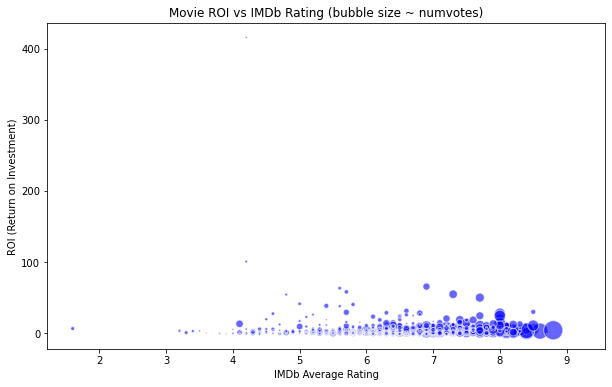

In [23]:
# --- 2. ROI vs IMDb Rating Scatterplot ---
plt.figure(figsize=(10,6))
plt.scatter(merged_rated["averagerating"], merged_rated["roi"], 
            alpha=0.6, s=merged_rated["numvotes"]/5000, c="blue", edgecolors="w")
plt.xlabel("IMDb Average Rating")
plt.ylabel("ROI (Return on Investment)")
plt.title("Movie ROI vs IMDb Rating (bubble size ~ numvotes)")
plt.show()

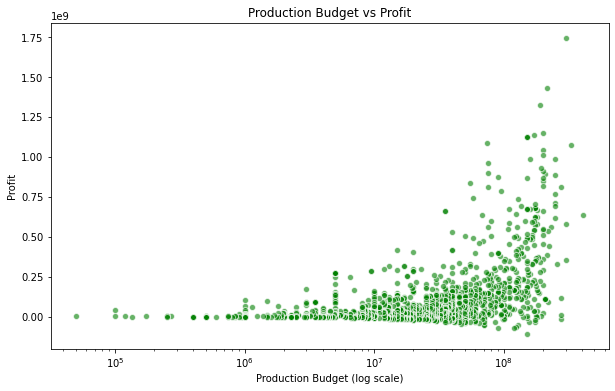

In [24]:
# --- 3. Budget vs Profit Scatterplot ---
plt.figure(figsize=(10,6))
plt.scatter(merged_rated["production_budget"], merged_rated["profit"],
            alpha=0.6, c="green", edgecolors="w")

plt.xscale("log")   # budgets span huge range → log scale helps
plt.xlabel("Production Budget (log scale)")
plt.ylabel("Profit")
plt.title("Production Budget vs Profit")
plt.show()

In [36]:
# --- Bottom 10 Movies by ROI (Flops) ---
bottom_roi = merged_rated.sort_values("roi", ascending=True).head(10)
print("Bottom 10 Movies by ROI (Flops)")
display(bottom_roi[["movie", "production_budget", "worldwide_gross", 
                    "profit", "roi", "averagerating", "numvotes"]])


Bottom 10 Movies by ROI (Flops)


,movie,production_budget,worldwide_gross,profit,roi,averagerating,numvotes
1262,Point Blank,3000000.0,0.0,-3000000.0,-1.000000,NaN,NaN
890,Snitch,850000.0,0.0,-850000.0,-1.000000,NaN,NaN
877,Trance,950000.0,0.0,-950000.0,-1.000000,NaN,NaN
1272,Eden,2300000.0,0.0,-2300000.0,-1.000000,NaN,NaN
1131,Perrierâs Bounty,6600000.0,828.0,-6599172.0,-0.999875,NaN,NaN
1079,Skin Trade,9000000.0,1242.0,-8998758.0,-0.999862,NaN,NaN
419,Mr. Nobody,46500000.0,22254.0,-46477746.0,-0.999521,NaN,NaN
1208,Falcon Rising,4500000.0,11774.0,-4488226.0,-0.997384,5.8,6955.0
851,Wolves,18000000.0,94953.0,-17905047.0,-0.994725,5.3,7312.0
989,5 Days of War,12000000.0,87793.0,-11912207.0,-0.992684,5.6,13089.0


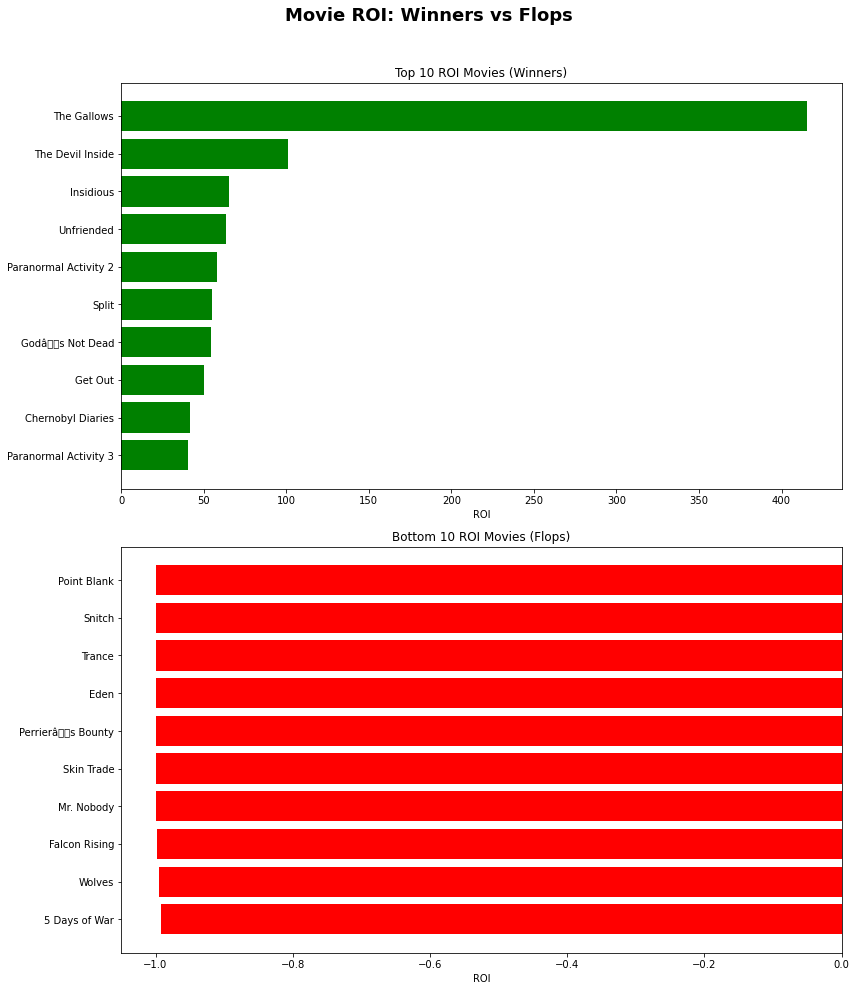

In [38]:
# --- Top 10 and Bottom 10 ROI Movies ---
top_roi = merged_rated.sort_values("roi", ascending=False).head(10)
bottom_roi = merged_rated.sort_values("roi", ascending=True).head(10)

# Wrap long titles
def wrap_labels(labels, width=30):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(12, 14), sharex=False)

# Top ROI
axes[0].barh(range(len(top_roi)), top_roi["roi"], color="green")
axes[0].set_title("Top 10 ROI Movies (Winners)")
axes[0].set_xlabel("ROI")
axes[0].set_yticks(range(len(top_roi)))
axes[0].set_yticklabels(wrap_labels(top_roi["movie"]))
axes[0].invert_yaxis()

# Bottom ROI
axes[1].barh(range(len(bottom_roi)), bottom_roi["roi"], color="red")
axes[1].set_title("Bottom 10 ROI Movies (Flops)")
axes[1].set_xlabel("ROI")
axes[1].set_yticks(range(len(bottom_roi)))
axes[1].set_yticklabels(wrap_labels(bottom_roi["movie"]))
axes[1].invert_yaxis()

plt.suptitle("Movie ROI: Winners vs Flops", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()